## Classify ASL Letters with Keras CNN 
### DataCamp project 
#### Erica Kotta 02/22/2022


In [353]:
# Import packages and set numpy random seed
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

np.random.seed(5) 
tf.random.set_seed(2)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


## Import Kaggle data stored at github links. 
#### Manually input image size, map (tuple) of letter values (that "label" index corresponds to)

In [354]:
# Import the training, test data from github links
train_data_link = "https://github.com/eck-nyu/classify_ASL_letter/blob/main/sign_mnist_train.csv?raw=true"
test_data_link = "https://github.com/eck-nyu/classify_ASL_letter/blob/main/sign_mnist_test.csv?raw=true"

image_size = (28,28)
theValues = ('ABCDEFGHIJKLMNOPQRSTUVWXYZ') # Map of label index to letter 

train_data = pd.read_csv(train_data_link)
test_data = pd.read_csv(test_data_link)

train_labels = train_data["label"].values
test_labels = test_data["label"].values

## Initial look at the data. Look at dataframe info, a few sample images 
### Look at training data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
Training data sample images


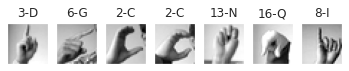

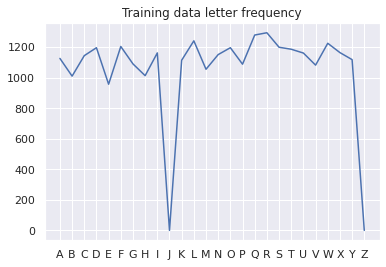

In [355]:
# First look at, open, plot the training data 
train_data.info()

# Plot a couple of images to see what it looks like
print("Training data sample images")
fig = plt.figure()
axes = []
for i in range(7):
  image = train_data.loc[i][1:len(train_data.loc[0])].values
  theLabel = train_data.loc[i][0] 
  
  axes.append( fig.add_subplot(1,7,i+1) )
  title_str = str(theLabel)+"-"+theValues[int(theLabel)]
  axes[-1].set_title(title_str)
  plt.imshow( image.reshape(image_size), cmap='gray')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

plt.show()


# Make a histogram of how many times each letter occurs in the training data
num_train_letters = np.zeros((1,len(theValues)));
for i in range(len(theValues)):
  num_train_letters[0][i] = sum(train_labels==i)

fig = plt.figure();
plt.plot( num_train_letters[0,:]);
plt.xticks(np.arange(0,len(theValues)), theValues);
plt.title("Training data letter frequency");

##### For some reason there are ZERO instances of J and Z in the training dataset???? 

### Look at testing data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB
Training data sample images


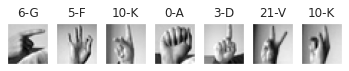

Text(0.5, 1.0, 'Test data letter frequency')

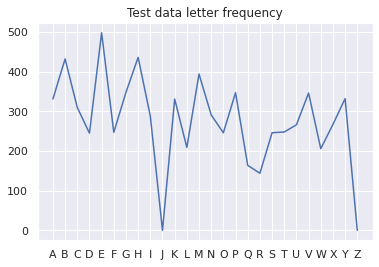

In [356]:
test_data.info()

# Plot a couple of images to see what it looks like
print("Training data sample images")
fig = plt.figure()
axes = []
for i in range(7):
  image = test_data.loc[i][1:len(test_data.loc[0])].values
  theLabel = test_data.loc[i][0] 
  
  axes.append( fig.add_subplot(1,7,i+1) )
  title_str = str(theLabel)+"-"+theValues[int(theLabel)]
  axes[-1].set_title(title_str)
  plt.imshow( image.reshape(image_size), cmap='gray')
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

plt.show()

# Make a histogram of how many times each letter occurs in the test data
num_test_letters = np.zeros((1,len(theValues)));
for i in range(len(theValues)):
  num_test_letters[0][i] = sum(test_labels==i)

fig = plt.figure();
plt.plot( num_test_letters[0,:]);
plt.xticks(np.arange(0,len(theValues)), theValues);
plt.title("Test data letter frequency")

##### At least there also seems to be 0 instances of J & Z in the test data too. 

### Re-format data to match inputs sizes for Keras modules 
#### Put images into RGB (original dataset images are 2d scalar arrays, so rescale pixel values [0,1] and repeat same values for R,G,B)

In [357]:
# Transform the training data images into 3d array (RGB)
time0 = time.perf_counter()
train_data_size = len(train_data["label"])
test_data_size = len(test_data["label"])

test_data_arr = np.zeros( (test_data_size, image_size[0], image_size[1], 3) )
for i in range(test_data_size):
  theImage = test_data.loc[i][1:len(test_data.loc[0])].values.reshape(image_size)
  theImage = (theImage - np.amin(theImage)) / (np.amax(theImage)-np.amin(theImage))
  test_data_arr[i, :, :, 0] = theImage
  test_data_arr[i, :, :, 1] = theImage
  test_data_arr[i, :, :, 2] = theImage

time1 = time.perf_counter()
print("Finished converting testing data in ",str(np.round(time1-time0,1))," s")

# Transform the test data images into 3d array (RGB)
train_data_arr = np.zeros( (train_data_size, image_size[0], image_size[1], 3) )
for i in range(train_data_size):
  theImage = train_data.loc[i][1:len(train_data.loc[0])].values.reshape(image_size)
  theImage = (theImage - np.amin(theImage)) / (np.amax(theImage)-np.amin(theImage))
  train_data_arr[i, :, :, 0] = theImage
  train_data_arr[i, :, :, 1] = theImage
  train_data_arr[i, :, :, 2] = theImage

time2 = time.perf_counter()
print("Finished converting training data in ",str(np.round(time2-time1,1))," s")

Finished converting testing data in  2.6  s
Finished converting training data in  8.8  s


#### Put data labels into one-hot format 

In [358]:
# Convert the training,test labels into arrays to input into model 
from keras.utils import np_utils 

# Then transform to one-hot format
train_labels_OH = np_utils.to_categorical(train_labels, num_classes=len(theValues))
test_labels_OH = np_utils.to_categorical(test_labels, num_classes=len(theValues))

## Build up the CNN model by adding layers 

In [364]:
model = Sequential()
model.add(Conv2D(filters=9, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(image_size[0], image_size[1], 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(4,4), padding="same"))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding="same", activation="relu"))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(4,4),padding="same"))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(len(theValues), activation='softmax'))

model.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 28, 28, 9)         684       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 7, 7, 9)          0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 7, 7, 15)          3390      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 2, 2, 15)         0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 60)                0         
                                                                 
 dense_17 (Dense)            (None, 26)              

## Compile & train the model, then evaluate score

In [365]:

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
hist = model.fit(train_data_arr, train_labels_OH, epochs=8, batch_size=32)

Epoch 1/8
858/858 [==============================] - 21s 23ms/step - loss: 1.7682 - categorical_accuracy: 0.4989
Epoch 2/8
858/858 [==============================] - 21s 25ms/step - loss: 0.4944 - categorical_accuracy: 0.8523
Epoch 3/8
858/858 [==============================] - 20s 23ms/step - loss: 0.1950 - categorical_accuracy: 0.9495
Epoch 4/8
858/858 [==============================] - 20s 23ms/step - loss: 0.0792 - categorical_accuracy: 0.9841
Epoch 5/8
858/858 [==============================] - 20s 23ms/step - loss: 0.0317 - categorical_accuracy: 0.9954
Epoch 6/8
858/858 [==============================] - 20s 23ms/step - loss: 0.0156 - categorical_accuracy: 0.9972
Epoch 7/8
858/858 [==============================] - 20s 24ms/step - loss: 0.0087 - categorical_accuracy: 0.9986
Epoch 8/8
858/858 [==============================] - 20s 23ms/step - loss: 0.0049 - categorical_accuracy: 0.9989


#### Plot the model performance (accuracy) on training data per iteration (epoch)

Looks like last ~4 epochs were unnecessary.


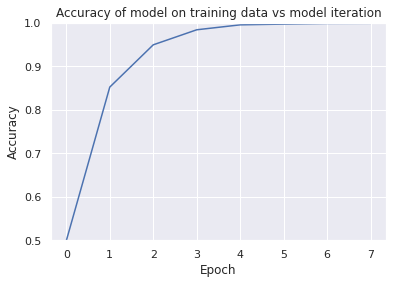

In [369]:
plt.plot(hist.history['categorical_accuracy'], label='accuracy')
# plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title("Accuracy of model on training data vs model iteration");

print("Looks like last ~4 epochs were unnecessary.")

### Evaluate the model performance on the test data 

In [370]:
# Obtain accuracy on test set
score = model.evaluate(x=test_data_arr, 
                       y=test_labels_OH)
print('Model accuracy on test data:', np.round(100*score[1],1),'%')

225/225 [==============================] - 2s 10ms/step - loss: 0.5579 - categorical_accuracy: 0.8893
Model accuracy on test data: 88.9 %


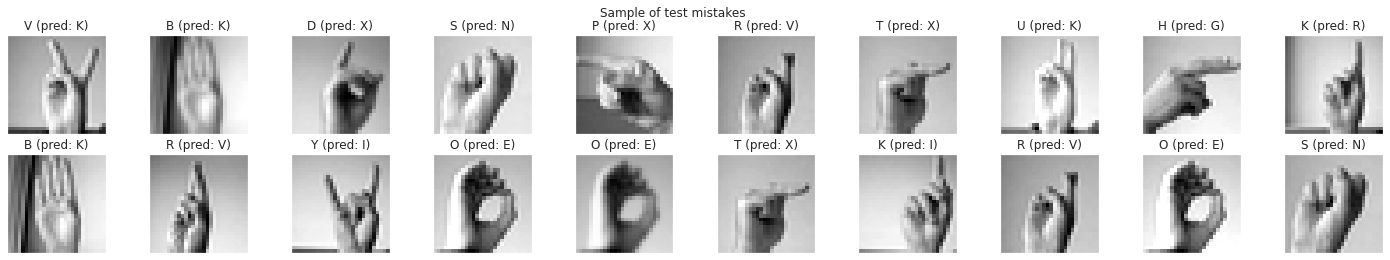

In [371]:
# Get predicted probabilities for test dataset
test_probs = model.predict(test_data_arr)

# Get predicted labels for test dataset
test_preds = np.argmax(test_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(test_labels != test_preds)[0]

# Choose a subset of mistakes to plot 
endVal = np.amin([20, len(bad_test_idxs)])
bad_test_idxs_plt = bad_test_idxs[0:endVal]

fig = plt.figure(figsize=(25,4))
for i, idx in enumerate(bad_test_idxs_plt):
    ax = fig.add_subplot(2, np.ceil(len(bad_test_idxs_plt)/2), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_data_arr[idx]))
    ax.set_title("{} (pred: {})".format(theValues[test_labels[idx]], theValues[test_preds[idx]]))
  
plt.suptitle("Sample of test mistakes");

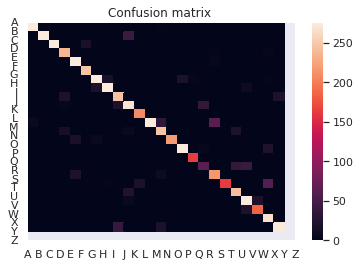

In [373]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()

conf_mat = confusion_matrix(test_labels, test_preds)

conf_mat_plt = conf_mat
threshVal = len(test_preds) / 26 # For plotting, set upper limit color to highlight off-diag entries
conf_mat_plt[conf_mat_plt > threshVal] = threshVal

ax = sns.heatmap(conf_mat_plt) 
plt.xticks(np.arange(0,len(theValues)), theValues);
plt.yticks(np.arange(0,len(theValues)), theValues);
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);
plt.title("Confusion matrix ");